In [7]:
import os
import re
import glob
from IPython.display import display
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
#import japanize_matplotlib
import seaborn as sns 
import unicodedata
import yaml


In [8]:
pd.set_option("display.max_columns",100)
pd.set_option("display.max_rows", 500)

In [26]:
# configの読み込み
CONFIG_FILE = '../configs/config.yaml'
with open(CONFIG_FILE, encoding="utf-8") as file:
    yml = yaml.safe_load(file)

In [168]:
DIR_HOME = yml["SETTING"]["DIR_HOME"]
DIR_INTERIM = yml["SETTING"]["DIR_INTERIM"]
DIR_FEATURE = yml["SETTING"]["DIR_FEATURE"]
DIR_RAW_DATA = yml["SETTING"]["DIR_RAW_DATA"]
FILE_NAME_TRAIN = yml["SETTING"]["FILE_NAME_TRAIN"]
FILE_NAME_TEST = yml["SETTING"]["FILE_NAME_TEST"]
TARGET_COL = yml["SETTING"]["TARGET_COL"]
KEY_COL = yml["SETTING"]["KEY_COL"]
DIR_LOG = yml["SETTING"]["DIR_LOG"]
FILE_NAME_SAMPLE_SUBMISSION = yml["SETTING"]["FILE_NAME_SAMPLE_SUBMISSION"]
DIR_SUBMISSION = yml["SETTING"]["DIR_SUBMISSION"]

# データ読み込み

In [91]:
dict_dtype = {
    "id": "int64",
    "Age": "object",
    "TypeofContact": "object",
    "CityTier": "int64",
    "DurationOfPitch": "object",
    "Occupation": "object",
    "Gender": "object",
    "NumberOfPersonVisiting": "int64",
    "NumberOfFollowups": "float64",
    "ProductPitched": "object",
    "PreferredPropertyStar": "float64",
    "NumberOfTrips": "object",
    "Passport": "int64",
    "PitchSatisfactionScore": "int64",
    "Designation": "object",
    "MonthlyIncome": "object",
    "customer_info": "object",
    "ProdTaken": "int64",
}

In [92]:
df_train = pd.read_csv(os.path.join(DIR_RAW_DATA, FILE_NAME_TRAIN), dtype=dict_dtype)
df_test = pd.read_csv(os.path.join(DIR_RAW_DATA, FILE_NAME_TEST), dtype=dict_dtype) 

In [93]:
df_all = pd.concat([df_train, df_test]).reset_index()

In [94]:
df_all.head()

,index,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,customer_info,ProdTaken
0,0,0,50歳,Self Enquiry,2,900秒,Large Business,male,1,4.0,Basic,3.0,5,1,4,Executive,253905.0,未婚 車未所持 子供なし,1.0
1,1,1,56歳,Company Invited,1,14分,Salaried,Male,1,4.0,Standard,3.0,2,1,4,Senior Manager,404475.0,"離婚済み,車あり,子供無し",0.0
2,2,2,NaN,Self Enquiry,1,10分,Large Business,Female,1,3.0,Basic,3.0,4,0,4,Executive,278145.0,"結婚済み、自動車未所有,子供なし",1.0
3,3,3,三十七歳,Self Enquiry,2,1080秒,Small Business,female,1,3.0,Standard,4.0,1,0,5,Senior Manager,326805.0,離婚済み、車所持、子供無し,0.0
4,4,4,48歳,Company Invited,3,1020秒,Small Business,female,1,3.0,Basic,4.0,4,0,4,Executive,258435.0,独身／車所持／無子,1.0


# 前処理

## Age

In [7]:
# 表記揺れの修正

In [95]:
def convert_full_to_half(df, col):
    """
    全角の数字を半角に変換
    """
    map_num_lower = {
        "０":"0",
        "１":"1",
        "２":"2",
        "３":"3",
        "４":"4",
        "５":"5",
        "６":"6",
        "７":"7",
        "８":"8",
        "９":"9"
    }   
    df[col] = df[col].replace(map_num_lower, regex=True)

    return df

def convert_kanji_to_int(df, col):
    """
    漢数字を数字に変換
    """
    df[col] = df[col].apply(lambda x: _convert_kanji_to_int(x))
    return df

def _convert_kanji_to_int(string):
    """
    漢数字を数字に変換
    """
    if string is np.nan:
        return string
    else:
        result = string.translate(str.maketrans("零〇一壱二弐三参四五六七八九拾", "00112233456789十", ""))
        convert_table = {"十": "0", "百": "00", "千": "000", "万": "0000", "億": "00000000", "兆": "000000000000", "京": "0000000000000000"}
        unit_list = "|".join(convert_table.keys())
        while re.search(unit_list, result):
            for unit in convert_table.keys():
                zeros = convert_table[unit]
                for numbers in re.findall(f"(\d+){unit}(\d+)", result):
                    result = result.replace(numbers[0] + unit + numbers[1], numbers[0] + zeros[len(numbers[1]):len(zeros)] + numbers[1])
                for number in re.findall(f"(\d+){unit}", result):
                    result = result.replace(number + unit, number + zeros)
                for number in re.findall(f"{unit}(\d+)", result):
                    result = result.replace(unit + number, "1" + zeros[len(number):len(zeros)] + number)
                result = result.replace(unit, "1" + zeros)
    return result

def integrate_age_kangi(df, col):
    """
    年齢の漢字を統一
    """
    map_age_kanji = {
        "才":"歳",
        "際":"歳",
    }
    df[col] = df[col].replace(map_age_kanji, regex=True)
    
    return df

In [96]:
df_all = convert_full_to_half(df_all, "Age")
df_all = convert_kanji_to_int(df_all, "Age")
df_all = integrate_age_kangi(df_all, "Age")

In [97]:
df_all["Age"].value_counts().index

Index(['33歳', '36歳', '30代', '37歳', '32歳', '34歳', '35歳', '31歳', '38歳', '39歳',
       '40代', '42歳', '30歳', '40歳', '41歳', '43歳', '50歳', '28歳', '29歳', '51歳',
       '52歳', '45歳', '46歳', '47歳', '49歳', '50代', '54歳', '53歳', '44歳', '48歳',
       '26歳', '27歳', '55歳', '25歳', '56歳', '24歳', '20代', '57歳', '22歳', '23歳',
       '58歳', '21歳', '59歳', '20歳', '60歳', '19歳', '18歳', '61歳', '60代', '10代'],
      dtype='object', name='Age')

## DurationOfPitch

In [98]:
def convert_duration_to_int(df, col):
    """
    秒と分の表記揺れを修正
    """
    df[col] = df[col].apply(lambda x: _convert_duration_to_int(x))
    df[col] = df[col].astype("float64")
    return df

def _convert_duration_to_int(string):
    if (string is np.nan) or (type(string)!=str):
        return string
    else:
        duration = string[:-1]
        kanji = string[-1]
        if kanji == "秒":
            result = int(duration)
        elif kanji == "分":
            result = int(duration) * 60
        else:
            result = string
        return result

In [99]:
df_all = convert_duration_to_int(df_all, "DurationOfPitch")

In [100]:
df_all["DurationOfPitch"].value_counts()

DurationOfPitch
480.0     671
540.0     654
900.0     569
960.0     527
840.0     518
600.0     467
420.0     446
780.0     397
1020.0    312
660.0     306
720.0     293
360.0     167
1080.0    133
1380.0    104
1920.0     93
1860.0     86
1440.0     86
1320.0     84
1500.0     79
2040.0     75
1980.0     69
1200.0     66
1260.0     65
1800.0     65
1560.0     64
2100.0     58
1620.0     57
1680.0     56
1140.0     50
1740.0     48
300.0      43
2160.0     15
240.0       3
Name: count, dtype: int64

## Gender

In [101]:
# 文字列の表記揺れを処理する関数
def normalize_text(df, col):
    df[col] = df[col].apply(_normalize_text)
    return df

def _normalize_text(text):
    # 半角
    text = unicodedata.normalize("NFKC", text)
    # 小文字
    text = text.lower()
    # スペース削除
    text = text.replace(" ", "")

    return text

In [102]:
df_all = normalize_text(df_all, "Gender")

In [103]:
df_all["Gender"].value_counts()

Gender
male      4218
female    2760
Name: count, dtype: int64

## NumberOfFollowups 

In [104]:
def convert_to_int(df, col):
    """
    float型のカラムをint型に変換
    """
    df[col] = df[col].astype("Int64")
    return df

def remove_zero(df, col):
    """
    0を削除
    """
    df[col] = df[col].apply(lambda x: x/100 if x >= 100 else x)
    return df

In [105]:
df_all = remove_zero(df_all, "NumberOfFollowups")
df_all = convert_to_int(df_all, "NumberOfFollowups")

In [106]:
df_all["NumberOfFollowups"].value_counts()

NumberOfFollowups
4    2777
3    2561
5    1122
2     213
1     178
6      70
Name: count, dtype: Int64

In [107]:
df_all["NumberOfFollowups"].isnull().sum()

57

## ProductPitched

In [108]:
map_special_char = {
    "ı": "i",
    "|": "l",
    "β": "B",
    "×": "x",
    "ᗞ": "D",
    "ς": "c",
    "𐊡": "B",
    "в": "B",
    "ꭰ": "D",
    "տ": "s",
    "ε": "e",
    "ꓢ": "S",
    "ѕ": "s",
    "с": "c",
    "ո": "n",
    "α": "a",
    "ι": "i",
    "е": "e",
    "μ": "m",
    "ѵ": "v",
    "а": "a",
}

def replace_special_char(text):
    result = []
    for c in text:
        result.append(map_special_char.get(c, c))
    return "".join(result)

In [109]:
# 文字列の表記揺れを処理する関数
def normalize_text_special_char(df, col):
    df[col] = df[col].apply(_normalize_text)
    df[col] = df[col].apply(replace_special_char)
    df[col] = df[col].apply(_normalize_text)
    return df

In [110]:
df_all = normalize_text_special_char(df_all, "ProductPitched")

In [111]:
df_all["ProductPitched"].value_counts()

ProductPitched
basic          2347
deluxe         2091
standard       1614
superdeluxe     640
king            286
Name: count, dtype: int64

## NumberOfTrips

In [112]:
def process_NumberOfTrips(df, col):
    df[col] = df[col].apply(_process_NumberOfTrips)
    return df

def _process_NumberOfTrips(text):
    if text is np.nan:
        return text
    else:
        num_char = re.findall(r"\d+", text)[0]
        if "半年に" in text:
            result = int(num_char) * 2
        elif "四半期に" in text:
            result = int(num_char) * 4
        else:
            result = int(num_char)
        return result

In [113]:
df_all = process_NumberOfTrips(df_all, "NumberOfTrips")

In [114]:
df_all["NumberOfTrips"].value_counts()

NumberOfTrips
2.0    2277
3.0    1706
5.0     977
1.0     801
7.0     513
4.0     333
6.0     281
8.0      26
Name: count, dtype: int64

## Designation

In [115]:
df_all = normalize_text_special_char(df_all, "Designation")

In [116]:
df_all["Designation"].value_counts()

Designation
executive        2330
manager          2117
seniormanager    1632
avp               635
vp                264
Name: count, dtype: int64

## MonthlyIncome

In [117]:
def convert_monthly_income_to_int(df, col):
    """
    月収の表記揺れを修正
    """
    df[col] = df[col].apply(lambda x: _convert_monthly_income_to_int(x))
    df[col] = df[col].astype("float64")
    return df

def _convert_monthly_income_to_int(monthly_income):
    if (monthly_income is np.nan):
        result =  monthly_income
    elif "月収" in monthly_income:
        num_char = re.findall(r"\d+", monthly_income)[0]
        result = float(num_char) * 10000
    else:
        result = monthly_income

    return result

In [118]:
df_all = convert_monthly_income_to_int(df_all, "MonthlyIncome")

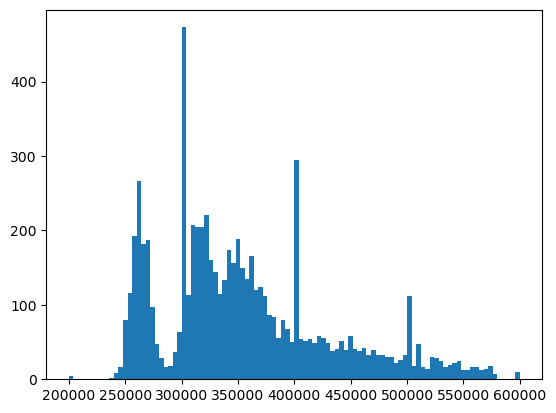

In [119]:
plt.hist(df_all["MonthlyIncome"].values, bins=100)
plt.show()

## customer_info

In [121]:
map_sep_char = {
    "　": " ",
    "／": " ",
    "、": " ",
    "/": " ",
    ",": " ",
    "-": " ",
    "ー": " ",
    "\n": " ",
    "\t": " ",
    }

map_car_char = {
    "車未所持": "未所有",
    "車所持": "所有",
    "自動車未所有": "未所有",
    "自動車所有": "所有",
    "自家用車なし": "未所有",
    "自家用車あり": "所有",
    "乗用車なし": "未所有",
    "乗用車所持": "所有",
    "車なし": "未所有",
    "車保有なし": "未所有",
    "車保有": "所有",
    "車あり": "所有",
}

map_child_char = {
    '子供1人': '1',
    '子供なし': '0',
    '子供2人': '2',
    'こども1人': '1',
    '子供無し': '0',
    'こども2人': '2',
    '子供有り': '有り',
    '1児': '1',
    '子供有り(1人)': '1',
    '子供ゼロ': '0',
    '無子': '0',
    '非育児家庭': '0',
    '子供有り(2人)': '2',
    '2児': '2',
    '子供3人': '3',
    '子供の数不明': '不明',
    'こども3人': '3',
    '不明': '不明',
    '3児': '3',
    '子育て状況不明': '不明',
    '子供有り(3人)': '3',
    '子の数不詳': '不明',
    'わからない': '不明'
 }

def replace_sep_char(text):
    result = []
    for c in text:
        result.append(map_sep_char.get(c, c))
    return "".join(result)

def replace_car(text):
    if text is np.nan:
        return text
    else:
        return map_car_char.get(text)
    
def replace_child(text):
    if text is np.nan:
        return text
    else:
        return map_child_char.get(text)
    
def devide_customer_info(df, col):
    df[col] = df[col].apply(replace_sep_char)
    df["marry"] = df[col].apply(lambda x: x.split(" ")[0])
    df["car"] = df[col].apply(lambda x: x.split(" ")[1])
    df["child"] = df[col].apply(lambda x: x.split(" ")[2])
    df["car"] = df["car"].apply(replace_car)
    df["child"] = df["child"].apply(replace_child)
    return df

In [122]:
df_all = devide_customer_info(df_all, "customer_info")

In [123]:
df_all["marry"].value_counts()

marry
結婚済み    2846
離婚済み    1688
独身      1309
未婚      1135
Name: count, dtype: int64

In [124]:
df_all["car"].value_counts()

car
未所有    3619
所有     3359
Name: count, dtype: int64

In [125]:
df_all["child"].value_counts()

child
1     2945
0     1909
2     1600
有り     321
3      129
不明      74
Name: count, dtype: int64

## データ出力

In [2]:
df_all.to_pickle(os.path.join(DIR_INTERIM, "preprocessed.pkl"))

NameError: name 'df_all' is not defined

# 特徴量作成

In [43]:
df_preprocessed = pd.read_pickle(os.path.join(DIR_INTERIM, "preprocessed.pkl"))

In [8]:
from pathlib import Path

In [9]:
class AbstractBaseBlock:

    def __init__(self, use_cache=False, save_cache=False, logger=None):
        self.use_cache = use_cache
        self.name = self.__class__.__name__
        self.cache_dir = Path(DIR_FEATURE)
        self.logger = logger
        self.seve_cache = save_cache
        self.use_cols = None
        
    # 内部状態の更新
    def fit(self, df_input: pd.DataFrame, y=None):
        pass
    
    # 変換処理
    def transform(self, df_input: pd.DataFrame) -> pd.DataFrame:
        raise NotImplementedError()
    
    # 内部状態の更新と変換処理をまとめて行う
    def fit_transform(self, df_input: pd.DataFrame, y=None):
        self.fit(df_input, y)
        return self.transform(df_input)
    
    # 特徴量生成処理
    def create_feature(self, df_input, y=None, test=False) -> pd.DataFrame:

        # クラス名.pkl
        file_name = self.cache_dir / f"{self.name}.pkl"

        # キャッシュを使う & ファイルがあるなら読み出し
        if os.path.isfile(str(file_name)) and self.use_cache:
            return pd.read_pickle(file_name)
        # 変換処理を実行
        else:
            # trainの場合
            if not test:
                feature = self.fit_transform(df_input, y)
            # testの場合
            else:
                feature = self.transform(df_input)
            # 保存する場合
            if self.seve_cache:
                feature.to_pickle(file_name)

            return feature

In [10]:
 # そのままのデータはpreprocessedデータから取得する

In [33]:
class CountEncodingBlock(AbstractBaseBlock):

    def __init__(self, use_cache=False, save_cache=False, logger=None):
        super().__init__(use_cache, save_cache, logger)
        self.use_cols = [
            "TypeofContact", "CityTier", "Occupation", "ProductPitched",
            "Designation", "marry", "car"
        ]
        self.key_col = "id"
        self.map_count = None

    def fit(self, df_input, y=None):
        # カラムごとにマッピング表を作成
        self.map_count = {}
        for col in self.use_cols:
            self.map_count[col] = df_input[col].value_counts()

    def transform(self, df_input):
        df_out = pd.DataFrame()
        df_out[[self.key_col]] = df_input[[self.key_col]]
        for col in self.use_cols:
            df_out[col] = df_input[col].map(self.map_count[col]).astype(int)
        # id以外のカラム名に接頭辞を付ける
        df_result = pd.concat([df_out[[self.key_col]], df_out.drop(columns=[self.key_col]).add_prefix('CE_')], axis=1)
        return df_result
        

In [35]:
from time import time

def decorate(s: str, decoration=None):
    if decoration is None:
        decoration = '★' * 20
        
    return ' '.join([decoration, str(s), decoration])

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' ', verbose=0):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None
        self.verbose = verbose

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        if self.verbose is None:
            return
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [36]:
feature_blocks = [
    *[CountEncodingBlock(use_cache=False, save_cache=True, logger=None)],
]

In [37]:
def run_blocks(df_input, feature_blocks, y=None, test=False):
    out_df = pd.DataFrame()
    
    print(decorate('start run blocks...'))

    with Timer(prefix='run test={}'.format(test)):
        for block in feature_blocks:
            with Timer(prefix='\t- {}'.format(str(block))):
                feature = block.create_feature(df_input, y=y, test=test)
            assert len(df_input) == len(feature), block

In [39]:
run_blocks(df_preprocessed, feature_blocks, y=None, test=False)

★★★★★★★★★★★★★★★★★★★★ start run blocks... ★★★★★★★★★★★★★★★★★★★★
	- <__main__.CountEncodingBlock object at 0x7fbf29c94e20> 0.043[s]
run test=False 0.044[s]


# モデル構築

In [119]:
# 特徴量生成
df_feature = pd.read_pickle(os.path.join(DIR_INTERIM, "preprocessed.pkl")).drop(columns=["index", "customer_info"])

In [143]:
import sys
from datetime import datetime
sys.path.append("/Users/ishizuka/pyworks/Competitions/signate_signatecup2024")
from src.model_lgb import ModelLGB
from src.runner import Runner
from src.util import Logger
from sklearn.preprocessing import LabelEncoder

In [265]:
import importlib
from src import runner
from src import model_lgb

# runnerモジュールをリロード
importlib.reload(runner)
importlib.reload(model_lgb)

# Runnerクラスを再インポート
from src.runner import Runner
from src.model_lgb import ModelLGB


In [22]:
def get_run_name(model_type):
    """run名の作成
    """
    run_name = model_type
    suffix = '_' + datetime.now().strftime("%Y%m%d%H%M")
    run_name = run_name + suffix
    return run_name

In [151]:
# lightgbmのパラメータ
params = {
        "boosting_type": "gbdt",
        "objective": "binary",
        "metric": "binary_logloss",
        "learning_rate": 0.1,
        "num_leaves": 31,
        "colsample_bytree": 0.5, # feature_fraction
        "subsample": 0.5,
        "reg_lambda": 5,
        "random_state": 71,
        'max_depth': 3,
        "min_data_in_leaf": 10,
        "num_leaves": 31,
        "num_boost_round": 5000,
        "early_stopping_rounds": 100,
        "verbose": True,
        "period": 100,
    }
run_setting = {
    "key": KEY_COL,       # データセットのID
    'target': TARGET_COL,       # 目的変数
    'calc_shap': False,     # shap値を計算するか否か
    'save_train_pred': False,    # trainデータに対する予測値を保存するか否か(閾値の最適化に使用)
    "hopt": False,           # パラメータチューニング、lgb_hopt,xgb_hopt,nn_hopt,False
    "target_enc": False,     # target encoding をするか否か
    "target_enc_col": ["OwnerID"]        # target encodingするカラムをリストで指定
    }

In [219]:
logger = Logger(path=DIR_LOG)
run_name = get_run_name(model_type="lgb")
run_name

'lgb_202408251922'

In [145]:
def transform_object_to_category(df):
    object_columns = df.select_dtypes(include=['object']).columns
    for col in object_columns:
        print(f"transform: {col}")
        df.loc[:, col] = df[col].astype('category')
    return df

def label_encoding(df):

    # カテゴリ変数のカラムを抽出
    obj_cols = df.dtypes[df.dtypes=="object"].index

    for col in obj_cols:
        df[col] = LabelEncoder().fit_transform(df[col])

    return df

In [229]:
df_train = df_feature[~df_feature[TARGET_COL].isnull()]
df_test = df_feature[df_feature[TARGET_COL].isnull()]
df_train = label_encoding(df_train)
df_test = label_encoding(df_test)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [266]:
# runnerクラスをインスタンス化
runner = Runner(run_name, ModelLGB, params, df_train, df_test, run_setting, logger)

In [246]:
runner.run_train_cv()

[2024-08-25 19:42:52] - lgb_202408251922 - start training cv
[2024-08-25 19:42:52] - lgb_202408251922 fold 0 - start training


[LightGBM] [Info] Number of positive: 389, number of negative: 2402
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 663
[LightGBM] [Info] Number of data points in the train set: 2791, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.139377 -> initscore=-1.820478
[LightGBM] [Info] Start training from score -1.820478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[2024-08-25 19:42:53] - lgb_202408251922 fold 0 - end training - score 0.8037900188323918
[2024-08-25 19:42:53] - lgb_202408251922 fold 1 - start training


[LightGBM] [Info] Number of positive: 408, number of negative: 2383
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 664
[LightGBM] [Info] Number of data points in the train set: 2791, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.146184 -> initscore=-1.764848
[LightGBM] [Info] Start training from score -1.764848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[2024-08-25 19:42:54] - lgb_202408251922 fold 1 - end training - score 0.8343111750705706
[2024-08-25 19:42:54] - lgb_202408251922 fold 2 - start training


[LightGBM] [Info] Number of positive: 396, number of negative: 2395
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 664
[LightGBM] [Info] Number of data points in the train set: 2791, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.141885 -> initscore=-1.799724
[LightGBM] [Info] Start training from score -1.799724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[2024-08-25 19:42:56] - lgb_202408251922 fold 2 - end training - score 0.8254141997114284
[2024-08-25 19:42:56] - lgb_202408251922 fold 3 - start training


[LightGBM] [Info] Number of positive: 400, number of negative: 2391
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 664
[LightGBM] [Info] Number of data points in the train set: 2791, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143318 -> initscore=-1.788002
[LightGBM] [Info] Start training from score -1.788002
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[2024-08-25 19:42:57] - lgb_202408251922 fold 3 - end training - score 0.8580372917988919
[2024-08-25 19:42:57] - lgb_202408251922 fold 4 - start training


[LightGBM] [Info] Number of positive: 395, number of negative: 2397
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 663
[LightGBM] [Info] Number of data points in the train set: 2792, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.141476 -> initscore=-1.803087
[LightGBM] [Info] Start training from score -1.803087
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[2024-08-25 19:42:58] - lgb_202408251922 fold 4 - end training - score 0.8741473059812159
[2024-08-25 19:42:58] - lgb_202408251922 - end training cv - score 0.8391399982788998
name:lgb_202408251922	score:0.8391399982788998	score0:0.8037900188323918	score1:0.8343111750705706	score2:0.8254141997114284	score3:0.8580372917988919	score4:0.8741473059812159
mean: 0.8391399982788998, std: 0.0246736921505721


In [247]:
runner.run_predict_cv()

[2024-08-25 19:42:58] - lgb_202408251922 - start prediction cv
[2024-08-25 19:42:58] - lgb_202408251922 - start prediction fold:0
[2024-08-25 19:42:58] - lgb_202408251922 - end prediction fold:0
[2024-08-25 19:42:58] - lgb_202408251922 - start prediction fold:1
[2024-08-25 19:42:58] - lgb_202408251922 - end prediction fold:1
[2024-08-25 19:42:58] - lgb_202408251922 - start prediction fold:2
[2024-08-25 19:42:58] - lgb_202408251922 - end prediction fold:2
[2024-08-25 19:42:58] - lgb_202408251922 - start prediction fold:3
[2024-08-25 19:42:58] - lgb_202408251922 - end prediction fold:3
[2024-08-25 19:42:58] - lgb_202408251922 - start prediction fold:4
[2024-08-25 19:42:58] - lgb_202408251922 - end prediction fold:4
[2024-08-25 19:42:58] - lgb_202408251922 - end prediction cv


In [267]:
runner.calc_feature_importance_cv()

In [ ]:
# runnerもrun_nameを指定して予測ができるように
# model_lgmもrun_nameを引数にしてモデルを再現できるように

# submit

In [208]:
df_submit = pd.read_csv(os.path.join(DIR_RAW_DATA, FILE_NAME_SAMPLE_SUBMISSION),  header=None)
df_submit.columns = ["id", "Pred"]
df_preds = pd.read_pickle(os.path.join(runner.out_dir_name, f'{runner.run_name}-pred.pkl'))

In [210]:
df_submition = pd.merge(df_submit["id"], df_preds, on="id", how="inner")
df_submition

,id,pred
0,3489,0.120576
1,3490,0.213760
2,3491,0.182973
3,3492,0.342989
4,3493,0.272268
...,...,...
3484,6973,0.133252
3485,6974,0.027438
3486,6975,0.625835
3487,6976,0.212867


In [211]:
df_submition.to_csv(os.path.join(DIR_SUBMISSION, f"{runner.run_name}.csv"), header=False, index=False)